# Tutorial: Source Count/Estimation using NMF

## Introduction
This tutorial introduces a Proof of Concept of using Non-negative Matrix Factorization (NMF) for counting in an unsupervised fashion the number of sources present in an audio data. This is based on the idea that NMF accurately performs Source Separation, and that simultaneous sources can be regrouped as similar sources. See the Tutorial on Source Separation for more details.

The actual script used for the experiments can be found in the folder "experiments", under the name "anuraset_nmf_count.py".

! Warning ! This must be understood as a Proof-of-Concept, because annotations correspond to the presence/absence of species, and not to the number of sources. Hence, several specimens of the same species may appear in one audio file.

## Objective
By the end of this tutorial, you will understand how to apply NMF to estimate the number sources from a mixed audio signal, and from a dataset (involving cross-validation for fixing the parameters of the clustering algorithm).

## Prerequisites
- Basic understanding of Python programming.
- Familiarity with linear algebra concepts.
- Installed Python environment with Jupyter Notebook.
- Required Python libraries: see the requirements.txt. This tutorial has been tested by installing `nmf_bioacoustics` using the command `pip install -e <path_to_the toolobox_on_your_machine>`.


## Conceptual Overview
NMF decomposes a non-negative data matrix into the product of two lower-rank non-negative matrices, often interpreted as the features and coefficients. In the context of audio, this allows us to separate original sources from a mixed signal, which can then be interpreted as similar or dissimilar sources.

# Let's dive into the code!
First, imports and parameters.

In [4]:
## Code to set up the virtual environment
# !pip install -r ../requirements.txt
# !pip install -e ..

## Download the AnuraSet dataset: visit https://zenodo.org/records/8342596
## Set up the path to the dataset here
anuraset_path = "/home/a23marmo/datasets/anuraset" # TO CHANGE

In [1]:
## Imports
from nmf_bioacoustic.datasets.anuraset import AnuraSet # Loader for the AnuraSet dataset

# Path to the dataset
anuraset_path = "/home/a23marmo/datasets/anuraset" # TO CHANGE

import nmf_bioacoustic.tasks.source_count as source_count # The scripts for estimating the number of sources based on the NMF outputs
from nmf_bioacoustic.utils.signal_to_spectrogram import FeatureObject # An object containing all details for the spectrogram computation

from nn_fac.nmf import nmf as nn_fac_nmf # Code for NMF

from nmf_bioacoustic.utils import audio_helper # High level function to listen to audio files from spectrograms

# Plotting functions
from librosa.display import specshow
import matplotlib.pyplot as plt

In [2]:
## Signal parameters
sr = 16000
hop_length = 512
n_fft = hop_length * 4
feature = "nn_log_mel" # The nn_log_mel (Nonnegative Log Mel Spectrogram, corresponding to log(mel + 1)) appeared to be the best performing feature in our experiments.

## Creating the feature object
feature_object = FeatureObject(sr, feature, hop_length, n_fft=n_fft)

# Loading the dataset
dataset = AnuraSet(audio_path=f"{anuraset_path}/raw_data/INCT17", annotations_file=f"{anuraset_path}/weak_labels.csv", 
                   feature_object=feature_object)

# Loading a specific file
file_name = "INCT17_20191113_040000.wav"

# NMF parameters
n_nmf = 10 # Number of components, fixed to 10 because it correponded to the maximum number of species in the annotations.
beta = 1 # The best performing beta in our experiments was 1

if beta == 2:
    nmf_algo = "hals"
else:
    nmf_algo = "mu"

Now, let's compute the spectrogram.

/home/a23marmo/environnements_venv/jjba/lib/python3.10/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


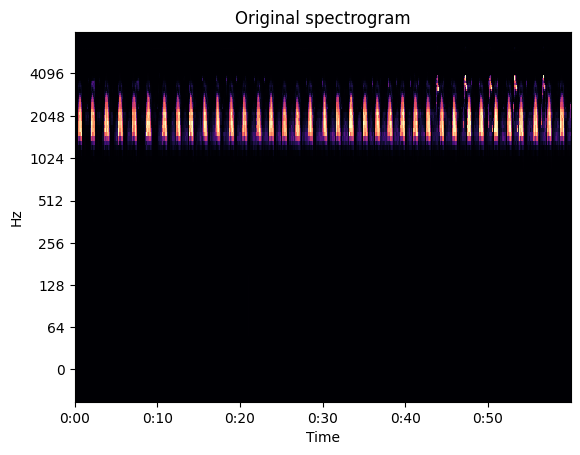

In [3]:
## Computing the spectrogram
if feature == "stft_complex":
    (spec, phase), annotations = dataset.get_item_of_id(file_name)
else:
    spec, annotations = dataset.get_item_of_id(file_name)

## Plot the spectrogram
fig, ax = plt.subplots()
ax.set_title("Original spectrogram")
img = specshow(spec, sr=sr, hop_length=hop_length, y_axis="log", x_axis = 'time', vmax=10) # specshow(W@H, sr=sr, hop_length=hop_length, y_axis="log")
# Save this figure as a png, with transparent background
# plt.savefig("imgs/original_spectrogram.png", transparent = True)
plt.show()

Now, let's compute NMF.

In [4]:
import time # Time the computation
start = time.time()

# Actually compute NMF
W, H = nn_fac_nmf(spec, n_nmf, init = "nndsvd", n_iter_max=100, tol=1e-8,
        update_rule = nmf_algo, beta = beta,
        normalize=[False, True],
        verbose=False, return_costs=False, deterministic=True)

print(f"NMF computation done in {time.time() - start} seconds.")

NMF computation done in 0.5082218647003174 seconds.


In [7]:
## Estimate the number of sources
## This is based on DBSCAN clustering of the NMF activations. If activations are simultaneous, they are considered to be from the same source.
## The two parameters are var_divide and eps. 
### var_divide: factor by which the variance of H is divided. All components of smaller variance are considered to be noise.
### eps: epsilon parameter for the DBSCAN clustering. The higher it is, the more components are considered to be from the same source.
estimated_number = source_count.estimate_number_sources(H, var_divide = 10, eps = 0.9)
print(f"Estimated number of sources: {estimated_number}, actual number of sources: {annotations}")

Estimated number of sources: 2, actual number of sources: 3


Plotting zone!

Below you will find the spectrograms of the NMF outputs.

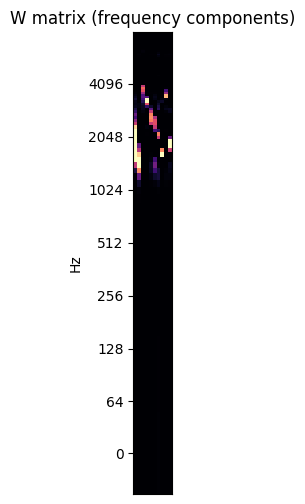

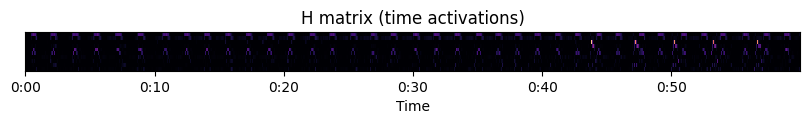

In [6]:
# Plot the spectrograms of the W and H matrices
fig, ax = plt.subplots(figsize=(0.5, 6))
img = specshow(W, sr=sr, hop_length=hop_length, y_axis="log", vmax=5)
ax.set_title("W matrix (frequency components)")
# plt.savefig("imgs/W.png", transparent = True)
plt.show()

fig, ax = plt.subplots(figsize=(10,0.5))
img = specshow(H[::-1], sr=sr, hop_length=hop_length, x_axis="time", vmax=5)
ax.set_title("H matrix (time activations)")
# plt.savefig("imgs/H.png", transparent = True)
plt.show()